## Tobigs 2주차 Optimization 과제
#### 15기 이윤정

----
# Gradient Descent 구현하기
 1)"..."표시되어 있는 빈 칸을 채워주세요  
 2)강의내용과 코드에 대해 공부한 내용을 마크마운 또는 주석으로 설명해주세요

## 데이터

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


## Train Test 데이터 나누기

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
#0.25 : 0.75로 분할
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size = 0.25, random_state = 0)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

## Scaling

experience와 salary의 단위, 평균, 분산이 크게 차이나므로 scaler를 사용해 단위를 맞춰줍니다. 

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


이때, scaler는 X_train에 fit되었으므로 X_test를 scaling할 때에는 transform만 해주면 된다. 

In [7]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


In [8]:
# parameter 개수
N = len(X_train.loc[0])

In [9]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
random_parameters = parameters.copy()
parameters

array([0.44929453, 0.99802964, 0.31350775])

### * LaTeX   

Jupyter Notebook은 LaTeX 문법으로 수식 입력을 지원하고 있습니다.  
LaTeX문법으로 아래의 수식을 완성해주세요  
http://triki.net/apps/3466  
https://jjycjnmath.tistory.com/117

## Dot product
## $z = X_i \theta$

In [89]:
def dot_product(X, parameters):
    z = 0
    for i in range(len(parameters)):
        z += X[i] * parameters[i]
    return z

내적 함수 이다. 

## Logistic Function

## $p = 1/(1+e^{-\beta *X})$

In [90]:
def logistic(X, parameters):
    z = dot_product(X, parameters)
    p = 1 / (1 + np.exp(-z)) 
    return p

sigmoid function로 불리며, 수식 상의 $\beta*X$는 Z로 표현되기도 한다.  
sigmoid function은 0에서 1 사이의 값만은 output으로 갖기 때문에 binary classification 혹은 확률 P를 나타내는 데 사용된다.

In [12]:
logistic(X_train.iloc[1], parameters)

0.8383903700275378

## Object function

Object Function : 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수입니다.  
<br>
선형 회귀의 목적함수
## $l(\theta) = \frac{1}{2}\Sigma(y_i - \theta^{T}X_i)^2$  
참고) $\hat{y_i} = \theta^{T}X_i$
  
로지스틱 회귀의 목적함수
## $l(p) =-\sum \left \{ y_{i}logp + (1-y_{i})log(1-p)  \right \}$

MSE를 목적함수 (=비용함수)로 사용하는 linear regression과 달리 logistic regression은 목적함수로 MSE를 사용하지 않는다. MSE를 목적함수로 Gradiant Descent 사용 시 Convex function이 아니게 되어 찾고자하는 최솟값이 아닌 다른 최솟값에 도달할 수 있기 때문이다.  
<br>
따라서, MSE를 대체할 수 있는 목적함수를 찾은 결과, 다음 조건을 만족한다.  
       $if, y = 1\rightarrow cost(p,y) = −log(p)$  
       $if, y = 0\rightarrow cost(p,y) = −log(1-p)$

In [13]:
def minus_log_cross_entropy_i(X, y, parameters):
    p = logistic(X, parameters)
    loss = (y*np.log(p)+(1-y)*np.log(1-p))
    return -loss

In [72]:
def mse_i(X, y, parameters):
    y_hat = np.dot(X, parameters.T)
    loss = np.square(np.subtract(y,y_hat))/2  
    return loss

In [67]:
def batch_loss(X_set, y_set, parameters, loss_function, n): #n:현재 배치의 데이터 수
    loss = 0
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        loss += loss_function(X, y, parameters)
    loss = loss / n #loss 평균값으로 계산
    return loss

In [16]:
batch_loss(X_test, y_test, parameters, minus_log_cross_entropy_i, len(X_test))

1.150046123401088

## Gradient
위의 선형회귀의 목적함수 $l(\theta)$와 로지스틱회귀의 목적함수 $l(p)$의 gradient를 작성해주세요.

## ${\partial\over{\partial \theta_j}}l(\theta)=-\Sigma(y_i - \theta^{T}X_i)X_{ij}$  
## ${\partial\over{\partial \theta_j}}l(p)=-\sum \left ( y_{i}-p_{i} \right )x_{ij}$ 

In [61]:

def get_gradient_ij(X, y, parameters, j, model):
    if model == 'linear':
        y_hat = np.dot(X, parameters.T)
        gradient = (y - y_hat) * X[j]
    else:
        p = logistic(X, parameters)
        gradient = -(y-p)*X[j]
    return gradient

In [63]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'logistic')

-0.08094620883776002

## Batch Gradient
배치 경사 하강법이란 매 경사 하강법 step에서 전체 훈련 세트 X에 대해 계산하는 기법으로, 특성 수에 민감하지 않지만 훈련 세트가 클수록 속도가 느려지는 단점이 존재한다. 

In [91]:
def batch_gradient(X_set, y_set, parameters, model):
    gradients = [0 for _ in range(len(parameters))]
    
    for i in range(len(X_set)):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        for j in range(len(parameters)):
            gradients[j] += get_gradient_ij(X, y, parameters, j, model)
    
    return gradients

In [20]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'logistic')
gradients1

[44.84195179561546, 18.204413828877563, 44.49454953197766]

## mini-batch
미니 배치라 불리우는 임의의 작은 샘플 세트에 대해 그레디언트를 계산하는 기법이다.

In [21]:
def batch_idx(X_train, batch_size):
    N = len(X_train)
    nb = (N // batch_size)+1 #number of batch
    idx = np.array([i for i in range(N)])
    idx_list = [idx[i*batch_size:(i+1)*batch_size] for i in range(nb) if len(idx[i*batch_size:(i+1)*batch_size]) != 0]
    return idx_list

batch_idx 함수에 대한 설명을 batch_size와 함께 간략하게 작성해주세요  
- batch_idx 함수는 parameter로 입력받은 batch_size를 기준으로 데이터를 인덱싱하여 미니배치로 만든다음 그레디언트를 계산하는 함수이다. 
- 미니배치를 어느 정도 크게 하면 Stochastic Gradient Descent(SGD)보다 최솟값에 더 가까이 도달할 수 있다고 한다. 다만, 해당 최솟값이 local minimum일 경우 빠져나오는 데 더 힘들다.

## Update Parameters
기울기를 갱신하는 코드를 작성해주세요  
(loss와 마찬가지로 기울기를 갱신할 때 배치 사이즈를 고려해 평균으로 갱신해주세요)

In [92]:
def step(parameters, gradients, learning_rate, n): #n:현재 배치의 데이터 수
    for i in range(len(parameters)):
        gradients[i] *= learning_rate / n
    
    parameters -= gradients
    return parameters

In [23]:
step(parameters, gradients1, 0.01, len(X_train))

array([0.44630507, 0.99681601, 0.31054145])

## Gradient Descent
위에서 작성한 함수들을 조합해서 경사하강법 함수를 완성해주세요

- learning_rate: 학습률  
- tolerance: Step이 너무 작아서 더 이상의 학습이 무의미할 때 학습을 멈추는 조건  
- batch: 기울기를 1번 갱신할 때 사용하는 데이터셋  
- epoch: 한 반복에서 훈련 세트의 샘플 수만큼 반복되는 데, 이때 각 반복을 의미
- num_epoch: 최대반복횟수 
<br>

BGD: 학습 한 번에 모든 데이터셋에 대해 기울기를 구한다.    
SGD: 학습 한 번에 임의의 데이터에 대해서만 기울기를 구한다.   
MGD: 학습 한 번에 데이터셋의 일부에 대해서만 기울기를 구한다.    

<br>
batch_size에 따른 경사하강법의 종류를 적어주세요. <br>      
batch_size=1 -> SGD  <br>
batch_size=k -> MGD  <br>
batch_size=whole -> BGD       

In [93]:
def gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 16):
    stopper = False
    
    N = len(X_train.iloc[0])
    parameters = np.random.rand(N)
    loss_function = minus_log_cross_entropy_i if model == 'logistic' else mse_i
    loss = 999
    batch_idx_list = batch_idx(X_train, batch_size)
    
    for epoch in range(num_epoch):
        if stopper:
            break
        for idx in batch_idx_list:
            X_batch = X_train.iloc[idx,]
            y_batch = y_train.iloc[idx]
            gradients = batch_gradient(X_batch, y_batch, parameters, model)
            parameters = step(parameters, gradients, learning_rate, batch_size)
            new_loss = batch_loss(X_batch, y_batch, parameters, loss_function, batch_size)
            
            if abs(new_loss - loss) < tolerance:
                stopper = True
                break
            loss = new_loss
        
        #100epoch마다 학습 상태 출력
        if epoch%100 == 0: #출력이 길게 나오면 check point를 수정해도 됩니다.
            print(f"epoch: {epoch}  loss: {new_loss}  params: {parameters}  gradients: {gradients}")
    
    return parameters

## Implement
경사하강법 함수를 이용해 최적의 모수 찾아보세요. 학습을 진행할 때, Hyper Parameter를 바꿔가면서 학습시켜보세요.

## Logistic Regression

#### 1. learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001

In [25]:
new_param_bgd = gradient_descent(X_train, y_train, batch_size = 150)
new_param_bgd

epoch: 0  loss: 0.7520044856529305  params: [0.30123424 0.34597166 0.05291009]  gradients: [0.029882521203362333, -0.002703105180106588, 0.01702461061568043]
epoch: 100  loss: 0.4436696763743217  params: [-0.84224023  0.94325681 -0.86469777]  gradients: [0.0035838399905870357, -0.005986841816376762, 0.0060625768360992845]
epoch: 200  loss: 0.38757044213019026  params: [-1.04713159  1.45193026 -1.36703742]  gradients: [0.0012757608093173208, -0.004315162997860895, 0.004214769856983426]
epoch: 300  loss: 0.3590698432566867  params: [-1.14997801  1.82631292 -1.73136549]  gradients: [0.0008688089846448446, -0.003265496379052847, 0.003166353113201251]
epoch: 400  loss: 0.3421216783194798  params: [-1.22782806  2.11645641 -2.01184028]  gradients: [0.0007048696881395603, -0.0025893750776444257, 0.00249537068066953]
epoch: 500  loss: 0.3311366726167629  params: [-1.29254201  2.3505288  -2.23682414]  gradients: [0.0005959075465002316, -0.00212313952024077, 0.0020354161476134553]
epoch: 600  los

array([-1.50586826,  3.08312175, -2.93334578])

In [26]:
new_param_sgd = gradient_descent(X_train, y_train, batch_size = 1)
new_param_sgd

epoch: 0  loss: 0.2808898919636226  params: [-0.86205675  1.09774093 -1.22428727]  gradients: [0.0253377851180744, 0.013788846896038971, 0.017827431026530904]
epoch: 100  loss: 0.07736671174749421  params: [-1.93032571  4.17501957 -4.0676912 ]  gradients: [0.007538543134334528, 0.004102482384080787, 0.005304049155899163]
epoch: 200  loss: 0.0773626655213781  params: [-1.9303681   4.1751431  -4.06780374]  gradients: [0.007538159521789448, 0.004102273621766841, 0.00530377924966401]
epoch: 300  loss: 0.07736266518361716  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489767122, 0.004102273604340261, 0.005303779227133398]
epoch: 400  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 500  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 600  loss: 0.077

array([-1.9303681 ,  4.17514311, -4.06780375])

In [27]:
new_param_mgd = gradient_descent(X_train, y_train, batch_size = 72)
new_param_mgd

epoch: 0  loss: 0.14383432238500782  params: [0.59739362 0.57735427 0.73717589]  gradients: [0.005489968851400484, 0.004943158059939121, 0.006247955084048144]
epoch: 100  loss: 0.02870588108827609  params: [-1.03683263  1.39765397 -1.31389325]  gradients: [0.00098480864057536, 0.001176464837135871, 0.001843736972057432]
epoch: 200  loss: 0.02329850729256944  params: [-1.22588689  2.1061324  -2.00238953]  gradients: [0.0008437446706171071, 0.0011085068945596462, 0.0015882553149786734]
epoch: 300  loss: 0.020641574995106434  params: [-1.35083953  2.55248698 -2.43053506]  gradients: [0.0007865029823557018, 0.0010800478274526773, 0.0014634323743798368]
epoch: 400  loss: 0.0190389937627049  params: [-1.44294672  2.86792139 -2.73050021]  gradients: [0.000755548802372873, 0.0010632824493877703, 0.001387953385386587]
epoch: 500  loss: 0.01796799758669633  params: [-1.51360561  3.10513544 -2.95467367]  gradients: [0.0007370613621296939, 0.0010527169393681442, 0.0013377772056523893]
epoch: 600  

array([-1.70746314,  3.74382152, -3.55243763])

---
#### 2. learning_rate = 0.001, num_epoch = 1000, tolerance = 0.00001
learning_rate 감소

In [28]:
new_param_bgd2 = gradient_descent(X_train, y_train, learning_rate = 0.001, batch_size = 150)
new_param_bgd2

epoch: 0  loss: 1.1221972148447468  params: [0.89510853 0.96789474 0.59016699]  gradients: [0.00036624843753308426, 0.00011987346630492903, 0.00031064867168187067]
epoch: 100  loss: 1.0979459786598849  params: [0.85867315 0.95600553 0.55924232]  gradients: [0.00036247884030796314, 0.00011791213256063098, 0.00030785166099342123]
epoch: 200  loss: 1.0741956810519968  params: [0.8226202  0.94431802 0.52860377]  gradients: [0.0003586008136834171, 0.00011584002504887193, 0.00030492706481683124]
epoch: 300  loss: 1.0509590624975986  params: [0.78696054 0.9328434  0.49826421]  gradients: [0.00035461396963380894, 0.0001136554850063232, 0.00030187298263151973]
epoch: 400  loss: 1.0282483748025306  params: [0.75170507 0.92159296 0.46823666]  gradients: [0.0003505184085954441, 0.00011135730934037094, 0.0002986880338405919]
epoch: 500  loss: 1.0060752696460407  params: [0.71686461 0.9105781  0.43853425]  gradients: [0.0003463147648762967, 0.00010894481578935033, 0.0002953714324199555]
epoch: 600  

array([0.54958107, 0.85953103, 0.29563473])

In [29]:
new_param_sgd2 = gradient_descent(X_train, y_train, learning_rate = 0.001, batch_size = 1)
new_param_sgd2

epoch: 0  loss: 1.2095137810389445  params: [-0.00902156  0.44470522  0.88434469]  gradients: [0.0007019208203959662, 0.0003819859818243497, 0.0004938649906999472]
epoch: 100  loss: 0.2947436613005141  params: [-0.96007212  1.05094432 -0.97004271]  gradients: [0.0002553645037082569, 0.000138969607166032, 0.00017967210059082]


array([-1.03714505,  1.36014727, -1.27605922])

In [30]:
new_param_mgd2 = gradient_descent(X_train, y_train, learning_rate = 0.001, batch_size = 72)
new_param_mgd2

epoch: 0  loss: 0.10018663975609157  params: [0.23446312 0.90645791 0.04659103]  gradients: [4.621131685822704e-05, 4.346017339170985e-05, 5.443463028858351e-05]
epoch: 100  loss: 0.09426991471445206  params: [ 0.18000721  0.8897524  -0.00432069]  gradients: [4.450274237108169e-05, 4.2071698392531995e-05, 5.286957719901172e-05]
epoch: 200  loss: 0.0888328308827762  params: [ 0.12768754  0.87481411 -0.05299949]  gradients: [4.279286690359129e-05, 4.0654204544346346e-05, 5.127795423872298e-05]
epoch: 300  loss: 0.0838579194418641  params: [ 0.07751213  0.86165161 -0.09943744]  gradients: [4.1097534665583335e-05, 3.92234682002808e-05, 4.967747028285346e-05]
epoch: 400  loss: 0.07932296905061582  params: [ 0.02947143  0.85025211 -0.14365159]  gradients: [3.9431414237490456e-05, 3.7795069876597916e-05, 4.8085275024363395e-05]
epoch: 500  loss: 0.0752020698286007  params: [-0.01646073  0.84058247 -0.1856827 ]  gradients: [3.780741467907447e-05, 3.638359914323402e-05, 4.6517125935181414e-05]


array([-0.2159718 ,  0.81592855, -0.36548845])

---
#### 3. learning_rate = 0.1, num_epoch = 10000, tolerance = 0.00001
num_epoch 증가

In [31]:
new_param_bgd3 = gradient_descent(X_train, y_train, num_epoch = 10000, batch_size = 150)
new_param_bgd3

epoch: 0  loss: 1.0255316007038509  params: [0.94710388 0.67718815 0.24961988]  gradients: [0.041692801871354344, 0.004096585311898844, 0.023368816084854485]
epoch: 100  loss: 0.4422640281513257  params: [-0.77598786  0.98382936 -0.89596869]  gradients: [0.005032166222939261, -0.005551919792339754, 0.005999635877510051]
epoch: 200  loss: 0.38589832570733207  params: [-1.04055032  1.4731046  -1.38771709]  gradients: [0.0014641440165372797, -0.004225300937278978, 0.00413042585134066]
epoch: 300  loss: 0.3581048338397383  params: [-1.15168446  1.841427   -1.74605652]  gradients: [0.0008958214047224435, -0.003223338941969022, 0.003123922536388928]
epoch: 400  loss: 0.34151594804793756  params: [-1.23057389  2.12828141 -2.02324036]  gradients: [0.000706192021224707, -0.0025633773225271998, 0.002469546627442465]
epoch: 500  loss: 0.3307298200944027  params: [-1.29514955  2.3601943  -2.24608964]  gradients: [0.0005931316865623776, -0.0021050855540694084, 0.0020176518544269668]
epoch: 600  los

array([-1.59173062,  3.36835455, -3.20144901])

In [32]:
new_param_sgd3 = gradient_descent(X_train, y_train, num_epoch = 10000, batch_size = 1)
new_param_sgd3

epoch: 0  loss: 0.28460936306821644  params: [-0.8575505   1.01823671 -1.14773408]  gradients: [0.025634681928999183, 0.013950418424516562, 0.01803632487396443]
epoch: 100  loss: 0.07736674774641093  params: [-1.93032533  4.17501847 -4.0676902 ]  gradients: [0.0075385465472963716, 0.0041024842414178865, 0.005304051557227518]
epoch: 200  loss: 0.07736266552438303  params: [-1.9303681   4.1751431  -4.06780374]  gradients: [0.007538159522074334, 0.004102273621921877, 0.0053037792498644536]
epoch: 300  loss: 0.07736266518361752  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489767166, 0.004102273604340285, 0.005303779227133429]
epoch: 400  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 500  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 600  loss

epoch: 5000  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 5100  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 5200  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 5300  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 5400  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 5500  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 560

array([-1.9303681 ,  4.17514311, -4.06780375])

In [33]:
new_param_mgd3 = gradient_descent(X_train, y_train, num_epoch = 10000, batch_size = 72)
new_param_mgd3

epoch: 0  loss: 0.07217584526185061  params: [0.00935875 0.2214215  0.19528654]  gradients: [0.003514505088737236, 0.0032414982216910425, 0.004445097916030034]
epoch: 100  loss: 0.02828443931190858  params: [-1.05266315  1.44008377 -1.35562159]  gradients: [0.0009664867320362995, 0.0011644430855933027, 0.001819856474024686]
epoch: 200  loss: 0.023134744876513156  params: [-1.23284367  2.13126244 -2.02660745]  gradients: [0.000839905789491904, 0.0011066059384107262, 0.001580509605916502]
epoch: 300  loss: 0.0205491356340153  params: [-1.35576914  2.56958074 -2.4468457 ]  gradients: [0.0007846220612652741, 0.0010790558881257444, 0.0014590708793663606]
epoch: 400  loss: 0.018979473387216606  params: [-1.44666472  2.88048835 -2.74240646]  gradients: [0.0007544694076422675, 0.001062677544457727, 0.0013851563984215406]
epoch: 500  loss: 0.01792659860986561  params: [-1.51650724  3.11481079 -2.96379177]  gradients: [0.000736388773478242, 0.001052323704836744, 0.001335845229830867]
epoch: 600 

epoch: 4900  loss: 0.014087002619573805  params: [-1.86589341  4.25811176 -4.02800261]  gradients: [0.0006915406282461089, 0.0010238756077429218, 0.0011611117137484213]
epoch: 5000  loss: 0.01408609560509151  params: [-1.86600212  4.25846301 -4.02832577]  gradients: [0.000691534813137605, 0.0010238713562812217, 0.0011610718620490023]
epoch: 5100  loss: 0.014085298957168202  params: [-1.86609761  4.25877156 -4.02860964]  gradients: [0.0006915297077272114, 0.001023867623349964, 0.0011610368602710617]
epoch: 5200  loss: 0.014084599219313147  params: [-1.8661815   4.25904261 -4.02885901]  gradients: [0.0006915252250034283, 0.0010238643454515894, 0.001161006116921321]
epoch: 5300  loss: 0.014083984581877521  params: [-1.86625519  4.25928072 -4.02907807]  gradients: [0.0006915212887131886, 0.0010238614669223487, 0.0011609791129325489]
epoch: 5400  loss: 0.014083444679105741  params: [-1.86631993  4.2594899  -4.02927052]  gradients: [0.000691517832011043, 0.0010238589389525694, 0.001160955392

epoch: 9800  loss: 0.014079553727879831  params: [-1.86678668  4.26099798 -4.03065795]  gradients: [0.0006914929471777915, 0.001023840735825786, 0.0011607844560205661]
epoch: 9900  loss: 0.014079552134985608  params: [-1.86678687  4.2609986  -4.03065852]  gradients: [0.0006914929369999729, 0.0010238407283792357, 0.0011607843860450657]


array([-1.86678704,  4.26099914, -4.03065901])

---
#### 4. learning_rate = 0.1, num_epoch = 1000, tolerance = 0.001
tolerance 감소  
- 그레디언트 벡터의 norm이 허용오차(tolerance)보다 작아지면 GD가 거의 최솟값에 도달했으므로, tolerance가 감소하면 그만큼 반복횟수는 증가한다.

In [34]:
new_param_bgd4 = gradient_descent(X_train, y_train, tolerance = 0.001, batch_size = 150)
new_param_bgd4

epoch: 0  loss: 0.9525312383397856  params: [0.00696778 0.95432555 0.85044846]  gradients: [0.021679977783459897, 0.016815240768904588, 0.03672601800619051]


array([-0.84447549,  0.84957239, -0.71683273])

In [35]:
new_param_sgd4 = gradient_descent(X_train, y_train, tolerance = 0.001, batch_size = 1)
new_param_sgd4

epoch: 0  loss: 0.2847814878818582  params: [-0.8511337   1.03042199 -1.1652916 ]  gradients: [0.02564839655203979, 0.013957881935492859, 0.018045974355762936]


array([-1.1107857 ,  1.66594158, -1.6882428 ])

In [36]:
new_param_mgd4 = gradient_descent(X_train, y_train, tolerance = 0.001, batch_size = 72)
new_param_mgd4

epoch: 0  loss: 0.12901964116875772  params: [0.62999923 0.77197119 0.31218432]  gradients: [0.005345689295156522, 0.0048408429869881845, 0.006043578200364318]


array([-0.44901537,  0.73540604, -0.53312455])

### Predict Label

In [37]:
y_predict = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_mgd3)
    if p> 0.5 :
        y_predict.append(1)
    else :
        y_predict.append(0)
y_predict_random = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], random_parameters)
    if p> 0.5 :
        y_predict_random.append(1)
    else :
        y_predict_random.append(0)

### Confusion Matrix

In [38]:
from sklearn.metrics import *

In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
confusion_matrix(y_test, y_predict)

array([[38,  2],
       [ 1,  9]], dtype=int64)

In [40]:
accuracy = (tp+tn) / (tp+fn+fp+tn)
print("accuracy:",accuracy)

accuracy: 0.94


## Linear regression
### $y = 0.5 + 2.7x$

### Data

In [74]:
raw_X = np.random.rand(150)
y = 2.7*raw_X + 0.5 + np.random.randn(150)

In [75]:
tmp = np.array([1 for _ in range(150)])
X = np.vstack((tmp, raw_X)).T
X = pd.DataFrame(X)
y = pd.Series(y)

### Estimation

In [76]:
#정규방정식
theta = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
theta

array([0.45289187, 2.60249534])

In [88]:
#경사하강법
new_param = gradient_descent(X, y, model = 'linear', learning_rate = 0.00001, batch_size = 72)
new_param

epoch: 0  loss: 1.652908043149421  params: [0.20763035 0.45493109]  gradients: [1.717237094248022e-05, 8.521360265637006e-06]
epoch: 100  loss: 1.6625043377877846  params: [0.20330336 0.45240731]  gradients: [1.7226891388218074e-05, 8.547648731687982e-06]
epoch: 200  loss: 1.6721670973073632  params: [0.19895971 0.44987486]  gradients: [1.7281617163732028e-05, 8.574035546491233e-06]
epoch: 300  loss: 1.68189680053088  params: [0.19459932 0.44733371]  gradients: [1.7336549040268183e-05, 8.600521079329329e-06]
epoch: 400  loss: 1.6916939298049936  params: [0.19022214 0.44478383]  gradients: [1.7391687791969147e-05, 8.627105700871696e-06]
epoch: 500  loss: 1.7015589710265198  params: [0.18582811 0.44222517]  gradients: [1.7447034195884904e-05, 8.653789783179826e-06]
epoch: 600  loss: 1.7114924136688519  params: [0.18141715 0.43965772]  gradients: [1.7502589031983745e-05, 8.680573699712504e-06]
epoch: 700  loss: 1.7214947508085838  params: [0.17698921 0.43708144]  gradients: [1.75583530831

array([0.16364771, 0.42932533])

In [102]:
y_hat_NE = theta.dot(X.T)
y_hat_GD = new_param.dot(X.T)

### Visualization
시각화를 통해 정규방정식과 경사하강법을 통한 선형회귀를 비교해보세요  
(밑의 코드를 실행만 시키면 됩니다. 추가 코드 x)

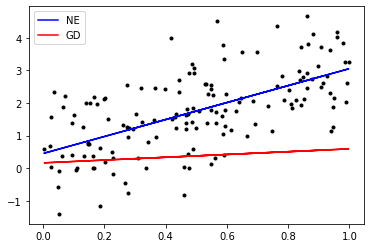

In [103]:
import matplotlib.pyplot as plt
plt.plot(X.iloc[:,1], y, '.k') #산점도
plt.plot(X.iloc[:,1], y_hat_NE, '-b', label = 'NE') #정규방정식
plt.plot(X.iloc[:,1], y_hat_GD, '-r', label = 'GD') #경사하강법
plt.legend()
plt.show()